### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [179]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [180]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [181]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [182]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [183]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [184]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [185]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [186]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [187]:
def cnf_mtx_metrics(cnf_matrix):

        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        TNR = TN/(FP+TN)

        return TPR, FPR, TNR, TN, FN, TP, FP

### Логистическая регрессия

In [188]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [189]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22390104, 0.33707751, 0.18489566, 0.09197292, 0.18590078,
       0.40873004, 0.18821398, 0.18360246, 0.43551361, 0.70866171])

In [190]:
cv_scores_LR = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')
cv_score_LR = np.mean(cv_scores_LR)
cv_score_std_LR = np.std(cv_scores_LR)
print('CV score is {}+-{}'.format(cv_score_LR, cv_score_std_LR))

CV score is 0.6716339396268689+-0.020925130227762587


In [191]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / ((precision + recall) + 0.000000000001) # исключим деление на ноль
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

thresholds_LR = thresholds[ix]
fscore_LR = fscore[ix]
precision_LR = precision[ix]
recall_LR = recall[ix]

Best Threshold=0.199920, F-Score=0.411, Precision=0.296, Recall=0.676


Confusion matrix, without normalization
[[1172  819]
 [ 166  343]]


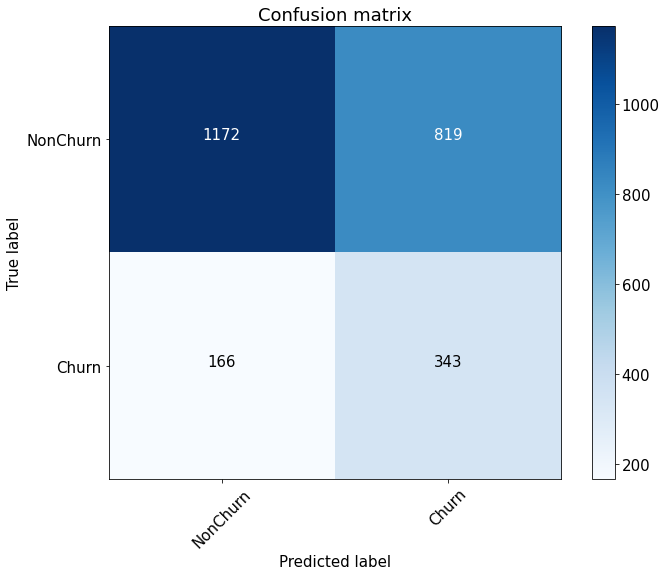

In [192]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_LR.png")
plt.show()

In [193]:
TPR_LR, FPR_LR, TNR_LR, TN_LR, FN_LR, TP_LR, FP_LR = cnf_mtx_metrics(cnf_matrix)
TPR_LR, FPR_LR, TNR_LR

(0.6738703339882122, 0.41135107985936714, 0.5886489201406329)

### GradientBoostingClassifier

In [194]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [195]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [196]:
cv_scores_GB = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')
cv_score_GB = np.mean(cv_scores_GB)
cv_score_std_GB = np.std(cv_scores_GB)
print('CV score is {}+-{}'.format(cv_score_GB, cv_score_std_GB))

CV score is 0.8636291150427254+-0.01685342398987631


In [197]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

thresholds_GB = thresholds[ix] 
fscore_GB = fscore[ix]
precision_GB = precision[ix]
recall_GB = recall[ix]

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


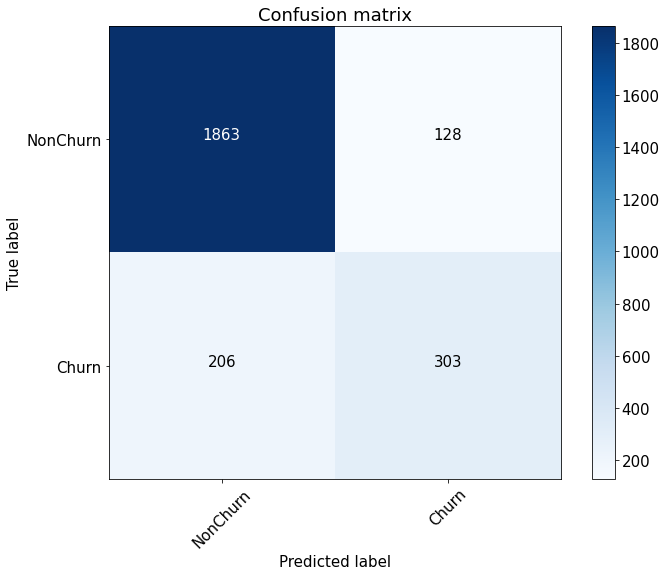

In [198]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_GB.png")
plt.show()

In [199]:
TPR_GB, FPR_GB, TNR_GB,TN_GB, FN2_GB, TP_GB, FP_GB = cnf_mtx_metrics(cnf_matrix)
TPR_GB, FPR_GB, TNR_GB

(0.5952848722986247, 0.06428930185836264, 0.9357106981416373)

### CatBoost

In [200]:
from catboost import CatBoostClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42, silent=True)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [201]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.46917705, 0.24499582, 0.11518556, 0.04942908, 0.02369729,
       0.87775373, 0.02032456, 0.13019025, 0.16192791, 0.91391094])

In [202]:
cv_scores_CB = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')
cv_score_CB = np.mean(cv_scores_CB)
cv_score_std_CB = np.std(cv_scores_CB)
print('CV score is {}+-{}'.format(cv_score_CB, cv_score_std_CB))

CV score is 0.8617128281872027+-0.013585080748554516


In [203]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

thresholds_CB = thresholds[ix] 
fscore_CB = fscore[ix]
precision_CB = precision[ix]
recall_CB = recall[ix]

Best Threshold=0.384476, F-Score=0.645, Precision=0.661, Recall=0.629


Confusion matrix, without normalization
[[1827  164]
 [ 190  319]]


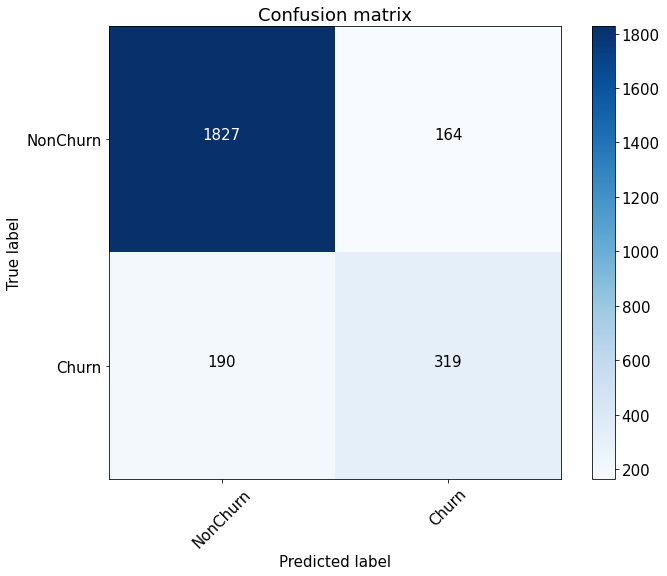

In [204]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_CB.png")
plt.show()

In [205]:
TPR_CB, FPR_CB, TNR_CB,TN_CB, FN2_CB, TP_CB, FP_CB = cnf_mtx_metrics(cnf_matrix)
TPR_CB, FPR_CB, TNR_CB

(0.6267190569744597, 0.08237066800602712, 0.9176293319939729)

In [206]:
metrics_table = pd.DataFrame({
                      'CV_score':[cv_score_LR,cv_score_GB,cv_score_CB],
                      'Best Threshold':[thresholds_LR,thresholds_GB,thresholds_CB], 
                      'F-Score':[fscore_LR,fscore_GB,fscore_CB], 
                      'Precision':[precision_LR,precision_GB,precision_CB], 
                      'Recall':[recall_LR,recall_GB, recall_CB], 
                      'Specificity':[1-FPR_LR, 1-FPR_GB, 1-FPR_CB],
                      'TPR': [TPR_LR, TPR_GB, TPR_CB ],
                      'FPR': [FPR_LR, FPR_GB, FPR_CB ],
                      'TNR': [TNR_LR, TNR_GB, TNR_CB ]
                       })
metrics_table.index = ['LogisticRegression', 'GradientBoostingClassifier', 'CatBoostClassifier']
metrics_table.round(3)

,CV_score,Best Threshold,F-Score,Precision,Recall,Specificity,TPR,FPR,TNR
LogisticRegression,0.672,0.200,0.411,0.296,0.676,0.589,0.674,0.411,0.589
GradientBoostingClassifier,0.864,0.409,0.646,0.704,0.597,0.936,0.595,0.064,0.936
CatBoostClassifier,0.862,0.384,0.645,0.661,0.629,0.918,0.627,0.082,0.918


### С небольшим перевесом побеждает GradientBoostingClassifier (cv-score, f-score)

In [207]:
costs = TP_GB + FP_GB  # Расходы
revenue = TP_GB * 2  # Доходы
print(f'Прибыль от применения модели Gradient Boosting {revenue - costs}$')

Прибыль от применения модели Gradient Boosting 175$


In [208]:
costs = TP_CB + FP_CB  # Расходы
revenue = TP_CB * 2  # Доходы
print(f'Прибыль от применения модели Cat Boosting {revenue - costs}$')

Прибыль от применения модели Cat Boosting 155$
